# Modeling Chicago Data
In this notebook we will be generating a few different model types to see if DST week ends up as a significant indicator in the prediction of traffic impact severity.

Starting off lets get all our imports taken care of and load in our data. For the purposes of our problem statement we will be looking at just our Chicago data.

In [1]:
import pandas as pd
import numpy as np

import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

In [2]:
pd.set_option("display.max_columns", None)

data = pd.read_csv('../data/chi_df_cleaned.csv')
data.head()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,start_time_ep,end_time_ep,weather_timestamp_ep,year,month,week,accident_duration,side_L,side_R,wind_direction_CALM,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_VAR,wind_direction_W,wind_direction_WNW,wind_direction_WSW,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Heavy Rain,weather_condition_Heavy Snow,weather_condition_Light Drizzle,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Rain,weather_condition_Snow,weather_condition_Thunder,weather_condition_Thunderstorms and Rain,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
0,2,42.305960,-87.960150,42.306916,-87.960918,0.077,37.0,31.0,79.0,29.59,10.0,8.1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480517e+09,1.480539e+09,1.480518e+09,2016,11,48,21600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,42.175870,-88.135770,42.174620,-88.135794,0.086,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480518e+09,1.480540e+09,1.480518e+09,2016,11,48,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,42.175897,-88.135769,42.174612,-88.135794,0.089,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480519e+09,1.480541e+09,1.480518e+09,2016,11,48,22524.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,41.860591,-87.992749,41.860590,-87.992700,0.003,37.0,30.4,76.0,29.61,10.0,9.2,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480522e+09,1.480544e+09,1.480522e+09,2016,11,48,21600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,41.750330,-87.663440,41.750330,-87.663440,0.000,37.9,30.0,73.0,29.65,10.0,12.7,0.0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.0,0.0,0.0,0.0,1.480524e+09,1.480545e+09,1.480524e+09,2016,11,48,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Baseline
Just to double check ourselves lets establish a basline which we'll be grading our model performance against. We can do this simply by checking the distribution of our target!

In [3]:
data['severity'].value_counts(normalize=True)

3    0.507627
2    0.412491
4    0.073805
1    0.006077
Name: severity, dtype: float64

Next step is to split our data into our features and target variable. While we're at it we'll go ahead and get our training and testing split. Since we can see that we have some imbalanced classes here we'll make sure to stratify our data to get an even sampling of all possible labels.

In [4]:
# X for features and y for target
X = data.drop(['severity'], axis=1)
y = data['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# making sure to take a quick glance at our data frames to ensure everything lines up
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (30729, 118)
y_train shape: (30729,)
X_test shape: (10244, 118)
y_test shape: (10244,)


## Scoring Functions
We'll be making a few different models here so to save ourselves some trouble going forward we'll make some functions that can output several metrics at once!

In [5]:
# compares the distribution of predicted values of our target to the distribution of our true values of our target
# outputs the values as a pandas dataframe
def compare_preds(true, preds):
    '''Compares the distribution of predicted values from a model to the distribution of our true values of our target. Outputs the values as a pandas dataframe'''
    
    true_labels = true.value_counts(normalize=True).sort_index(ascending=False).index
    true_values = true.value_counts(normalize=True).sort_index(ascending=False).values
    pred_values = pd.DataFrame(preds).value_counts(normalize=True).sort_index(ascending=False).values
    
    compare = pd.DataFrame([true_labels, true_values, pred_values]).T
    column_dict = {0:'Severity',1:'True Label Distribution',2:'Predicted Label Distribution'}
    
    return pd.DataFrame(compare).rename(columns=column_dict).set_index('Severity')

In [6]:
def print_scores(model_name, model, xtrain, ytrain, xtest, ytest, preds):
    '''Takes in a fit model along with training data, testing data, and predictions, then outputs a baseline accuracy score for training and testing data, a classification report, and a confusion matrix'''
    print(f'{model_name} Accuracy Scores')
    print('-'*53)
    print(f'{model_name} Training:', model.score(xtrain,ytrain))
    print(f'{model_name} Testing:', model.score(xtest,ytest))
    print('-'*53)
    print('Classification Report')
    print('-'*53)
    print(classification_report(y_test, preds, zero_division=0))
    plot_confusion_matrix(model, xtest, ytest, cmap='ocean_r');

## Modeling
We'll be taking a look at four different models here. We're starting with a decision tree and random forrest so that we can gain insight into what factors are the best predictors of accident severity.

Decision Tree Accuracy Scores
-----------------------------------------------------
Decision Tree Training: 0.7991148426567737
Decision Tree Testing: 0.7886567746973838
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.02      0.03        62
           2       0.78      0.82      0.80      4226
           3       0.80      0.88      0.84      5200
           4       0.55      0.06      0.11       756

    accuracy                           0.79     10244
   macro avg       0.66      0.44      0.45     10244
weighted avg       0.77      0.79      0.76     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
4.0,0.073805,0.008493
3.0,0.507627,0.558668
2.0,0.412491,0.432643
1.0,0.006077,0.000195


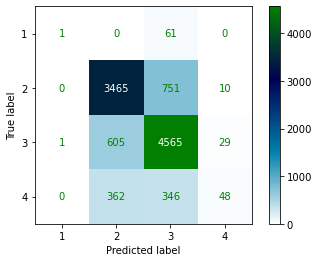

In [7]:
# decision tree model with just a few hyperparameters
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=42)
tree.fit(X_train,y_train)
tree_preds = tree.predict(X_test)
print_scores('Decision Tree', tree, X_train, y_train, X_test, y_test, tree_preds)
compare_preds(y,tree_preds)

Overall performance we're off to a decent start but its clear that our decision tree is performing poorly when predicting severity 1 and 4 accidents. Let's take a look at our feature importances.

In [8]:
tree_coefs = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns=['feature','coefficient'])
tree_coefs[tree_coefs['coefficient'] > 0].sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
31,weather_timestamp_ep,0.163638
35,accident_duration,0.154699
26,civil_twilight,0.108469
101,hour_15,0.095057
102,hour_16,0.090352
103,hour_17,0.089872
104,hour_18,0.083321
4,distance(mi),0.051378
92,hour_06,0.022971
29,start_time_ep,0.019909


In [9]:
tree_coefs[tree_coefs['feature'] == 'is_DST']

,feature,coefficient
117,is_DST,0.0


It looks like this first model doesn't feel DST is important at all when determining traffic severity. Let's see if we get a different result when moving onto a random forrest model.

Random Forest Accuracy Scores
-----------------------------------------------------
Random Forest Training: 0.8018484168049725
Random Forest Testing: 0.7863139398672394
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.80      0.80      0.80      4226
           3       0.78      0.90      0.83      5200
           4       0.80      0.01      0.02       756

    accuracy                           0.79     10244
   macro avg       0.59      0.43      0.41     10244
weighted avg       0.78      0.79      0.75     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
4.0,0.073805,0.000976
3.0,0.507627,0.584147
2.0,0.412491,0.414877
1.0,0.006077,NaN


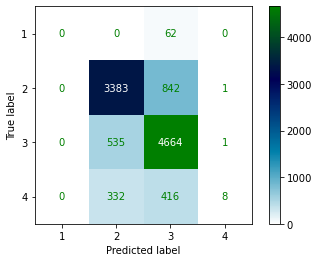

In [10]:
forest = RandomForestClassifier(max_depth=10, random_state=42)
forest.fit(X_train,y_train)
forest_preds = forest.predict(X_test)
print_scores('Random Forest', forest, X_train, y_train, X_test, y_test, forest_preds)
compare_preds(y,forest_preds)

In [11]:
forest_coefs = pd.DataFrame(zip(X_train.columns, forest.feature_importances_), columns=['feature','coefficient'])
forest_coefs[forest_coefs['coefficient'] > 0].sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
31,weather_timestamp_ep,0.094899
29,start_time_ep,0.092878
30,end_time_ep,0.085910
35,accident_duration,0.065688
102,hour_16,0.051168
32,year,0.047919
103,hour_17,0.047037
4,distance(mi),0.040374
25,sunrise_sunset,0.031991
26,civil_twilight,0.028757


In [12]:
forest_coefs[forest_coefs['feature'] == 'is_DST']

,feature,coefficient
117,is_DST,0.00073


It looks like we aren't getting much feedback for prediction from DST still. The model is performing very slightly better overall but still struggling with our 1 and 4 severity columns

BAG Classifier Accuracy Scores
-----------------------------------------------------
BAG Classifier Training: 0.9912460542158873
BAG Classifier Testing: 0.8249707145646232
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.10      0.16        62
           2       0.82      0.85      0.83      4226
           3       0.83      0.87      0.85      5200
           4       0.78      0.42      0.54       756

    accuracy                           0.82     10244
   macro avg       0.73      0.56      0.60     10244
weighted avg       0.82      0.82      0.82     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
4.0,0.073805,0.039242
3.0,0.507627,0.529383
2.0,0.412491,0.430203
1.0,0.006077,0.001171


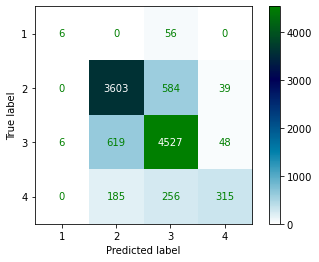

In [13]:
bag = BaggingClassifier(bootstrap_features=True, random_state=42)
bag.fit(X_train,y_train)
bag_preds = bag.predict(X_test)
print_scores('BAG Classifier', bag, X_train, y_train, X_test, y_test, bag_preds)
compare_preds(y,bag_preds)

In [14]:
# credit to gorjan in the following post for some insight on how to get average feature importance in a bag model
# https://stackoverflow.com/questions/54519113/feature-importance-in-logistic-regression-with-bagging-classifier
bag_fi = np.mean([dtc.feature_importances_ for dtc in bag.estimators_], axis=0)
bag_coefs = pd.DataFrame(zip(X_train.columns, bag_fi), columns=['feature','coefficient'])
bag_coefs[bag_coefs['coefficient'] > 0].sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
19,roundabout,0.047774
30,end_time_ep,0.030117
96,hour_10,0.023975
44,wind_direction_NNE,0.023905
6,wind_chill(f),0.022905
71,weather_condition_Light Thunderstorms and Snow,0.022046
21,stop,0.021567
33,month,0.017822
104,hour_18,0.017239
80,day_Monday,0.016526


In [15]:
bag_coefs[bag_coefs['feature'] == 'is_DST']

,feature,coefficient
117,is_DST,0.013486


Our BAG model is continuing the trend of improvment but it's still struggling heavily on our severity 1 accidents. It is however, performing much better on severity 4 accidents even if we would like to see a bit more accuracy overall. We can also see that its starting to take DST into more account but still only a small consideration overall. For the sake of seeing how accurate we can get we'll give an XGBoost model going. Since it's a boosting technique we will not be able to check on the effect of individual coefficients very well but we likely will get some solid performance metrics!

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy Scores
-----------------------------------------------------
XGBoost Training: 0.9133391909922224
XGBoost Testing: 0.8489847715736041
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.48      0.23      0.31        62
           2       0.85      0.87      0.86      4226
           3       0.86      0.89      0.88      5200
           4       0.77      0.45      0.57       756

    accuracy                           0.85     10244
   macro avg       0.74      0.61      0.65     10244
weighted avg       0.85     

,True Label Distribution,Predicted Label Distribution
Severity,,
4.0,0.073805,0.043147
3.0,0.507627,0.528016
2.0,0.412491,0.426005
1.0,0.006077,0.002831


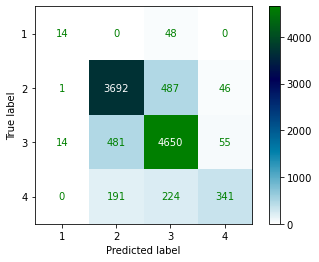

In [16]:
xg_model = xg.sklearn.XGBClassifier(random_state=42)
xg_model.fit(X_train,y_train)
xg_preds = xg_model.predict(X_test)
print_scores('XGBoost', xg_model, X_train, y_train, X_test, y_test, xg_preds)
compare_preds(y,xg_preds)

By far the best performance metrics of any of our models yet! This has been the only model that has gotten anywhere close to identifying our severity 1 incidents correctly even if there's still room for improvement. We can't get much information about the importance of each of the features from this method but we might be able to make a useful app with this technique! Move over to the streamlit model prep notebook with us to see how we can make simplify this model and apply it to other sets of city data we've collected.

To really find out if DST has an impact on traffic we'll have to take a different approach. We'll move over to some hypothesis testing to see if it is statistically significant!